In [3]:
!pip install mip

In [4]:
from mip import *

### Creating Models

Create an empty Mixed-Integer Linear Programming model

In [6]:
m = Model(sense = MINIMIZE,solver_name = CBC) # Sense can be MAXIMIZE and solver_name can be GRB if Gurobi installation is found in the system

Include decision variables, objective function and constraints

In [7]:
x = m.add_var() # single variable with domain in $\mathbb{R}^{+}$

In [8]:
n = 10
y = [m.add_var(var_type = BINARY) for i in range(n)] # 10 binary decision variables stored in a list, available variable types are CONTINOUS and INTEGER

In [9]:
z = m.add_var(name = 'zCost',var_type=INTEGER, lb = -10, ub = 10) # name is optional, lb is lower bound and ub is upper bound

Can always reference a variable using var_by_name() function, BUT here our variables (x,y,z) are already referenced

Include Constraints

In [13]:
m += x + y <=10
m += xsum(w[i]*x[i] for i in range(n)) <= c # summation expression
m += xsum(w[i]*x[i] for i in range(n) if i%2 == 0) <= c, 'even_sum' # conditional expression and naming the constraint

can reference any constraint using constr_by_name() function

In [14]:
constraint = m.constr_by_name('even_sum')

Include Objective Function  

**By default a model is created with Minimize sense**

In [17]:
m.objective = xsum(c[i]*x[i] for i in range(n)) # this is automatically set as a minimization since in our model definition above the sense is MINIMIZE 
                                                # We can change the sense to MAXIMIZE or explicitly claim it as below
m.objective = maximize(xsum(c[i]*x[i] for i in range(n)))

### Saving, Loading and Checking Model Properties

In [ ]:
m.write('model.lp') # .lp or .mps file formats are suitable for saving and debugging
m.read('model.lp')
print('model has {} vars, {} constraints and {} nzs'.format(m.num_cols,m.num_rows,m.num_nz))

### Optimizing and Querying Optimization Results

MIP solvers execute a Branch-&-Cut (BC) algorithm that in finite time will provide the optimal solution. For BC algorithm take a look at [BC algorithm](https://en.wikipedia.org/wiki/Branch_and_cut).

In [2]:
m.max_mip_gap = 0.05  # specifies the allowable percentage deviation of the upper bound from the lower bound for concluding the search
status = m.optimize(max_seconds = 300).   # max_seconds specifies the max time for solving the model
if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value,m.objective_bound))
elif status == OptimizationStatus.NO_SOLUTION_FOUND:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    print('solution:')
    for v in m.vars:
        if abs(v.x) > 1e-6:
            print('{}:{}'.format(v.name,v.x))

SyntaxError: invalid syntax (<ipython-input-2-5f9eb6a49390>, line 2)

Check all the parameters for optimize function, also check model property **emphasis** and **cuts** for performance tuning and controlling how much computational effort should be spent in generating cutting planes

### For a concise example of Integer Linear programming using branch and Bound, watch the following video

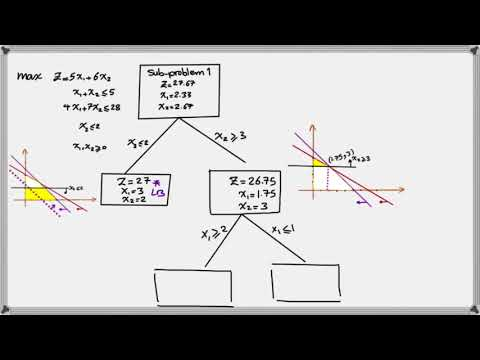

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('upcsrgqdeNQ',width = 1200, height = 400)

### Solving some famous examples

#### The 0/1 Knapsack Problem

##### Story

given a set $𝐼$ of items, each one
with a weight $𝑤_𝑖$ and estimated profit $𝑝_𝑖$, one wants to select a subset with maximum profit such that the
summation of the weights of the selected items is less or equal to the knapsack capacity $𝑐$. Considering a
set of decision binary variables $𝑥_𝑖$ that receive value $1$ if the $𝑖$-th item is selected, or $0$ if not.

##### Mathematical Model

\begin{equation}
\begin{aligned}
\min_{x} \quad & \sum_{i \in I} p_i \cdot x_i \\
\textrm{s.t.} \quad & \sum_{i \in I} w_i \cdot x_i \leq c \\
\textrm{} \quad & x_i \in \{0,1\} \quad \forall i \in I \\
\end{aligned}
\end{equation}

##### Modeling

In [18]:
from mip import Model,xsum,maximize,BINARY

def solve_Knapsack(I,p,w,c):
    # I (int) : number of items
    # p (list) : list of profit for each item len(p) = I
    # w (list) : weight of each item len(w) = I
    # c (float) : knpasack capacity
    
    m = Model("Knapsack")
    x = [m.add_var(var_type = BINARY) for i in range(I)]
    m.objective = maximize(xsum(p[i]*x[i] for i in range(I)))
    m += xsum(w[i]*x[i] for i in range(I)) <= c
    m.optimize()
    results = [x[i].x for i in range(I)]
    print('result is',results)
    
    selected = [i for i in range(I) if x[i].x >= 0.99]
    print("selected items: {}".format(selected))
    
solve_Knapsack(6,[10, 13, 18, 31, 7, 15],[11, 15, 20, 35, 10, 33],47)

result is [1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
selected items: [0, 3]


#### The Traveling Salesman Problem

##### Story

Consider that you will spend some time in Belgium and wish to visit some of its main tourist
attractions, depicted in the map bellow:  
*You want to find the shortest possible tour to visit all these places.*

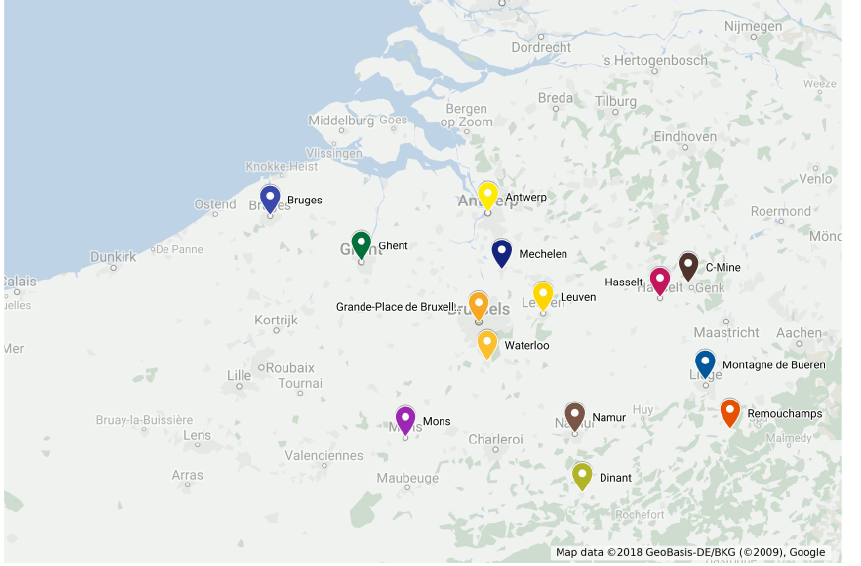

In [22]:
from IPython.display import Image
Image(filename='Assets/TSP.png')

##### Mathematical Model

considering $𝑛$ points $𝑉 = \{0,\cdots, 𝑛 − 1\}$ and a distance matrix $𝐷^{𝑛\times 𝑛}$ with elements $𝑐_{𝑖,𝑗} \in \mathbf{R}^{+}$, a solution consists in a set
of exactly $𝑛$ (origin, destination) pairs indicating the itinerary of your trip, resulting in the following formulation:

\begin{equation}
\begin{aligned}
\min_{x} \quad & \sum_{i \in V \textrm{,} j \in V} c_{i,j}\cdot x_{i,j} \\
\textrm{s.t.} \quad & \sum_{j \in V-\{i\}}x_{i,j} = 1 \quad \forall i \in V \\
\textrm{} \quad & \sum_{i \in V-\{j\}}x_{i,j} = 1 \quad \forall j \in V \\
\textrm{} \quad & y_i - (n+1)\cdot x_{i,j} \geq y_j-n \quad \forall i \in V-\{0\}, j \in V-\{0,i\}\\
\textrm{} \quad & x_{i,j} \in \{0,1\} \quad \forall i \in V, j \in V\\
\textrm{} \quad & y_i \geq 0 \quad \forall i \in V
\end{aligned}
\end{equation}

The solution enforce that we leave and arrive only once at each point and also connected routes are enforced using variable $y$

##### Modeling

In [54]:
from itertools import product
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY


def solve_TSP(name_of_places,distance_matrix):
    # name_of_places (list) : name of cities
    # distance_matrix: and upper triangular matrix of pairwise distances between cities
    
    n, V = len(distance_matrix),set(range(len(distance_matrix)))
    
    c == [[0 if i ==j
           else dists[i][j-i-1] if j > i
           else dists[j][i-j-1]
           for j in V] for i in V]
    
    model = Model()
    
    x = [[model.add_var(var_type = BINARY) for j in V] for i in V]
    y = [model.add_var() for i in V]
    model.objective = minimize(xsum([c[i][j]*x[i][j] for i in V for j in V]))
    
    for i in V:
        model += xsum(x[i][j] for j in V - {i}) == 1
        model += xsum(x[j][i] for j in V - {i}) == 1
    
    for (i,j) in product(V-{0},V-{0}):
        if i != j:
            model += y[i] - (n+1)*x[i][j] >= y[j]-n
    
    model.optimize()
    
    
    if model.num_solutions:
        out.write('route with total distance %g found: %s'%(model.objective_value,name_of_places[0]))
        nc = 0
        while True:
            nc = [i for i in V if x[nc][i].x >= 0.99][0]
            out.write(' -> %s' %places[nc])
            if nc == 0:
                break
            out.write('\n')
            
            
            
places = ['Antwerp', 'Bruges', 'C-Mine', 'Dinant', 'Ghent',
'Grand-Place de Bruxelles', 'Hasselt', 'Leuven',
'Mechelen', 'Mons', 'Montagne de Bueren', 'Namur',
'Remouchamps', 'Waterloo']          
            
dists = [[83, 81, 113, 52, 42, 73, 44, 23, 91, 105, 90, 124, 57],
[161, 160, 39, 89, 151, 110, 90, 99, 177, 143, 193, 100],
[90, 125, 82, 13, 57, 71, 123, 38, 72, 59, 82],
[123, 77, 81, 71, 91, 72, 64, 24, 62, 63],
[51, 114, 72, 54, 69, 139, 105, 155, 62],
[70, 25, 22, 52, 90, 56, 105, 16],
[45, 61, 111, 36, 61, 57, 70],
[23, 71, 67, 48, 85, 29],
[74, 89, 69, 107, 36],
[117, 65, 125, 43],
[54, 22, 84],
[60, 44],
[97],
[]]

solve_TSP(places,dists)

route with total distance 547 found: Antwerp -> Mechelen
 -> Leuven
 -> Hasselt
 -> C-Mine
 -> Montagne de Bueren
 -> Remouchamps
 -> Dinant
 -> Namur
 -> Mons
 -> Waterloo
 -> Grand-Place de Bruxelles
 -> Ghent
 -> Bruges
 -> Antwerp

#### n-Queens

##### Story

In the $𝑛$-queens puzzle $𝑛$ chess queens should to be placed in a board with $𝑛 \times 𝑛$ cells in a way that no
queen can attack another, i.e., there must be at most one queen per row, column and diagonal. This is a
constraint satisfaction problem: any feasible solution is acceptable and no objective function is defined.

#### Mathematical Model

\begin{equation}
\sum_{j=1}^{n} x_{ij} = 1 \quad \forall i \in \{1,\cdots n\}\\
\sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \{1,\cdots n\}\\
\sum_{i=1}^{n} \sum_{j=1:i-j=k}^{n} x_{i,j} \leq 1 \quad \forall i \in \{1,\cdots n\}, k \in \{2-n,\cdots,n-2\}\\
\sum_{i=1}^{n} \sum_{j=1:i+j=k}^{n} x_{i,j} \leq 1 \quad \forall i\in \{1,\cdots n\}, k \in \{3,\cdots,n+n-1\}\\
x_{i,j} \in \{0,1\} \quad \forall i \in \{1,\cdots n\}, j \in \{1,\cdots n\}\\
\end{equation}

##### Modeling

In [61]:
from sys import stdout
from mip import Model,xsum,BINARY

def solve_nQueens(n):
    # n (int): number of queens
    queens = Model()
    x = [[queens.add_var('x({},{})'.format(i,j),var_type=BINARY) for j in range(n)] for i in range(n)]
    
    for i in range(n):
        queens += xsum(x[i][j] for j in range(n)) == 1,'row({})'.format(i)
    
    for j in range(n):
        queens += xsum(x[i][j] for i in range(n)) == 1,'row({})'.format(j)
        
    for p,k in enumerate(range(2-n,n-2+1)):
        queens += xsum(x[i][i-k] for i in range(n) if 0 <= i - k <n) <= 1,'diag1({})'.format(p)
    
    for p,k in enumerate(range(3,n+n)):
        queens += xsum(x[i][k-i] for i in range(n) if 0 <= k - i <n) <= 1,'diag2({})'.format(p)
        
    queens.optimize()
    
    if queens.num_solutions:
        stdout.write('\n')
        for i,v in enumerate(queens.vars):
            stdout.write('o ' if v.x >= 0.99 else '. ')
            if i % n == n-1:
                stdout.write('\n')
        
        
solve_nQueens(20)


. . . . . . . . . . . . o . . . . . . . 
o . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . o . . . . 
. . . . . . . . o . . . . . . . . . . . 
. o . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . o . . . 
. . . . . . . . . . o . . . . . . . . . 
. . . . . . . . . . . . . o . . . . . . 
. . . . . . . . . . . . . . . . . o . . 
. . . . . . . . . o . . . . . . . . . . 
. . . o . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . o 
. . . . . . . . . . . . . . o . . . . . 
. . o . . . . . . . . . . . . . . . . . 
. . . . . o . . . . . . . . . . . . . . 
. . . . . . . o . . . . . . . . . . . . 
. . . . . . . . . . . o . . . . . . . . 
. . . . . . . . . . . . . . . . . . o . 
. . . . . . o . . . . . . . . . . . . . 
. . . . o . . . . . . . . . . . . . . . 


#### Bandwidth Multicoloring Problem

##### Story

The design of wireless networks, such as cell phone networks, involves assigning communication frequencies
to devices. These communication frequencies can be separated into channels. The geographical area
covered by a network can be divided into hexagonal cells, where each cell has a base station that covers a
given area. Each cell requires a different number of channels, based on usage statistics and each cell has
a set of neighbor cells, based on the geographical distances. The design of an efficient mobile network
involves selecting subsets of channels for each cell, avoiding interference between calls in the same cell
and in neighboring cells. Also, for economical reasons, the total bandwidth in use must be minimized,
i.e., the total number of different channels used. Each cell has a demand with the required number of channels and
a sequential id. The problem has the following input data:  
- N: set of cells, numbered from 1 ro n
- $r_i \in \mathbf{Z}^{+}$: demand of cell $i\in N$, i.e., the required number of channels
- $d_{i,j} \in \mathbf{Z}^{+}$: minimum distance between channels assigned to nodes $𝑖$ and $𝑗$, $𝑑_{𝑖,𝑖}$ indicates the minimum distance between different channels allocated to the same cell.  

Given an upper limit $\bar{u}$ on the maximum number of channels $𝑈 = \{1,\cdots,\bar{u}\}$ this problem can be formulated as a mixed integer program with binary variables indicating the composition
of the subsets: binary variables $𝑥_{(𝑖,𝑐)}$ indicate if for a given cell $𝑖$ channel $𝑐$ is selected $(𝑥_{(𝑖,𝑐)} = 1)$
or not $(𝑥_{(𝑖,𝑐)} = 0)$.



#### Mathematical Model

\begin{equation}
\begin{aligned}
\min z\\
\textrm{s.t.} \quad & \sum_{c=1}^{\bar{u}}x_{(i,c)} = r_i \quad \forall i \in N\\
\textrm{} \quad & z \geq c\cdot x_{(i,c)} \quad \forall i \in N, c\in U\\
\textrm{} \quad & x_{(i,c)} + x_{(j,c')} \leq 1 \quad \forall (i,j,c,c') \in N \times N \times N \times N: i \neq j \wedge |c - c'| < d_{(i,j)}\\
\textrm{} \quad & x_{(i,c)} + x_{(i,c')} \leq 1 \quad \forall i,c \in N \times U, c' \in \{c+1,\cdots,\min(c+d_{i,i},\bar{u})\}\\
\textrm{} \quad & x_{(i,c)} \in \{0,1\} \quad \forall i \in N,c \in U\\
\textrm{} \quad & z \geq 0\\
\end{aligned}
\end{equation}

##### Modeling

In [67]:
from itertools import product
from mip import Model,xsum,minimize,BINARY

def solve_BMP(r,d,mNodes):
    # r (list) : number of channels per node
    # d (matrix) : distance between channels in the same node (i,i) and in adjacent nodes
    # mNodes (int) : maximum number of nodes
    
    N = range(len(r))
    U = range(sum(d[i][j] for (i,j) in product(N,N)) + sum(el for el in r))
    
    m = Model()
    x = [[m.add_var('x({},{})'.format(i,c),var_type = BINARY) for c in U] for i in N]
    
    z = m.add_var('z')
    m.objective = minimize(z)
    
    for i in N:
        m += xsum(x[i][c] for c in U) == r[i]
    
    for i,j,c1,c2 in product(N,N,U,U):
        if i != j and c1 <= c2 < c1+d[i][j]:
            m += x[i][c1] + x[j][c2] <= 1
    
    for i,c1,c2 in product(N,U,U):
        if c1 < c2 < c1+d[i][i]:
            m += x[i][c1] + x[i][c2] <= 1
    
    for i,c in product(N,U):
        m += z >= (c+1)*x[i][c]
        
    m.optimize(max_nodes = mNodes)
    
    if m.num_solutions:
        for i in N:
            print('Channels of node %d: %s' % (i,[c for c in U if x[i][c].x >= 0.99]))
            
            
r = [3, 5, 8, 3, 6, 5, 7, 3]
d = [[3, 2, 0, 0, 2, 2, 0, 0],
    [2, 3, 2, 0, 0, 2, 2, 0], 
    [0, 2, 3, 0, 0, 0, 3, 0], 
    [0, 0, 0, 3, 2, 0, 0, 2], 
    [2, 0, 0, 2, 3, 2, 0, 0], 
    [2, 2, 0, 0, 2, 3, 2, 0], 
    [0, 2, 2, 0, 0, 2, 3, 0], 
    [0, 0, 0, 2, 0, 0, 0, 3]] 


solve_BMP(r,d,10)

Channels of node 0: [18, 21, 25]
Channels of node 1: [7, 11, 80, 88, 92]
Channels of node 2: [2, 5, 9, 21, 25, 28, 51, 94]
Channels of node 3: [7, 14, 96]
Channels of node 4: [38, 45, 52, 57, 66, 72]
Channels of node 5: [5, 34, 41, 49, 60]
Channels of node 6: [0, 19, 69, 83, 86, 90, 97]
Channels of node 7: [2, 11, 67]


#### Resource Constrained Project Scheduling

#### Story

The Resource-Constrained Project Scheduling Problem (RCPSP) is a combinatorial optimization problem
that consists of finding a feasible scheduling for a set of $𝑛$ jobs subject to resource and precedence
constraints. Each job has a processing time, a set of successors jobs and a required amount of different
resources. Resources may be scarce but are renewable at each time period. Precedence constraints
between jobs mean that no jobs may start before all its predecessors are completed. The jobs must be
scheduled non-preemptively, i.e., once started, their processing cannot be interrupted.
The RCPSP has the following input data:  

- I jobs set
- R renewable resources set
- S set of precedences between jobs $(𝑖,𝑗) \in I \times I$
- T planning horizon: set of possible processing times for jobs
- $𝑝_𝑗$ processing time of job $𝑗$
- $𝑢_{(𝑗,𝑟)}$ amount of resource $𝑟$ required for processing job $𝑗$
- $𝑐_𝑟$ capacity of renewable resource $𝑟$. 

In addition to the jobs that belong to the project, the set $I$ contains jobs $0$ and $𝑛+1$, which are dummy
jobs that represent the beginning and the end of the planning, respectively. The processing time for the
dummy jobs is always zero and these jobs do not consume resources.

##### Modeling

\begin{equation}
\begin{aligned}
\min{x} \quad & \sum_{t \in T} t\cdot x_{(n+1,t)} \\
\textrm{s.t.} \quad & \sum_{t \in T} x_{(j,t)} = 1 \quad \forall j \in I \\
\textrm{} \quad & \sum_{j \in I} \sum_{t_2 = t - p_j + 1}^{t} u_{(j,r)}x_{(j,t_2)} \leq c_r \quad \forall t \in T, r \in R\\
\textrm{} \quad & \sum_{t \in T}t \cdot x_{(s,t)} - \sum_{t \in T} t \cdot x_{(j,t)} \geq p_j \quad \forall (j,s) \in S\\
\textrm{} \quad & x_{(j,t)} \in \{0,1\} \quad \forall j \in I, t \in T\\
\end{aligned}
\end{equation}

In this formulation,
decision variables $𝑥_{(𝑗,𝑡)} = 1$ if job $𝑗$ is assigned to begin at time $𝑡$; otherwise, $𝑥_{(𝑗,𝑡)} = 0$. All jobs must
finish in a single instant of time without violating precedence constraints while respecting the amount of available resources.

##### Modeling

In [72]:
from itertools import product
from mip import Model,xsum,BINARY

def solve_RCPS(n,p,u,c,S):
    # n (int) : number of jobs (note: total number of jobs will be n + 2)
    # p (list) : list of processing time for each job
    # u (list of lists) : list of lists of size two indicating amount of resources for each job (note: each list should be the size of c)
    # c (list) : number of resources
    # S (list of lists) : list of lists that indicates precedence between jobs (note: each list should be of size 2)
    
    (R,I,T) = (range(len(c)),range(len(p)),range(sum(p)))
    
    model = Model()
    
    x = [[model.add_var(name="x({},{})".format(j,t),var_type=BINARY) for t in T] for j in I]
    
    model.objective = xsum(t*x[n+1][t] for t in T)
    
    for j in I:
        model += xsum(x[j][t] for t in T) == 1
    
    for (r,t) in product(R,T):
        model += (xsum(u[j][r]*x[j][t2] for j in I for t2 in range(max(0,t-p[j]+1),t+1)) <= c[r])
    for (j,s) in S:
        model += xsum(t*x[s][t] - t*x[j][t] for t in T) >= p[j]
        
    model.optimize()
    print("Schedule: ")
    for (j,t) in product(I,T):
        if x[j][t].x >= 0.99:
            print("Job {}: begins at t = {} and finishes at t={}".format(j,t,t+p[j]))
    print("Makespan = {}".format(model.objective_value))
    
    
n = 10 
p = [0, 3, 2, 5, 4, 2, 3, 4, 2, 4, 6, 0]
u = [[0, 0], [5, 1], [0, 4], [1, 4], [1, 3], [3, 2], [3, 1], [2, 4],[4, 0], [5, 2], [2, 5], [0, 0]]
c = [6, 8]
S = [[0, 1], [0, 2], [0, 3], [1, 4], [1, 5], [2, 9], [2, 10], [3, 8], [4, 6],[4, 7], [5, 9], [5, 10], [6, 8], [6, 9], [7, 8], [8, 11], [9, 11], [10, 11]]
solve_RCPS(n,p,u,c,S)

Schedule: 
Job 0: begins at t = 0 and finishes at t=0
Job 1: begins at t = 0 and finishes at t=3
Job 2: begins at t = 0 and finishes at t=2
Job 3: begins at t = 10 and finishes at t=15
Job 4: begins at t = 3 and finishes at t=7
Job 5: begins at t = 5 and finishes at t=7
Job 6: begins at t = 7 and finishes at t=10
Job 7: begins at t = 7 and finishes at t=11
Job 8: begins at t = 16 and finishes at t=18
Job 9: begins at t = 11 and finishes at t=15
Job 10: begins at t = 15 and finishes at t=21
Job 11: begins at t = 21 and finishes at t=21
Makespan = 21.0
